# Titianic Kaggale

## Link: [Kaggle](https://www.kaggle.com/c/titanic)


## Loading Libraries

In [1037]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import random
plt.rcParams['figure.figsize'] = (12.0, 10.0) # set default size of plots
%matplotlib inline

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import preprocessing 

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

## My libs
from tqdm import tqdm
from xgboost import XGBClassifier
import xgboost as xgb

#extra
CSI   = "\x1B["

## Load Data

In [1038]:
# Load in the train and test datasets
Train = pd.read_csv('Data/train.csv')
Test = pd.read_csv('Data/test.csv')

# Store our passenger ID for easy access
PassengerId = Test['PassengerId']

## head
#Train.head(10)
# '''
# Variable	Definition	Key
# survival	Survival	0 = No, 1 = Yes
# pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
# sex	Sex	
# Age	Age in years	
# sibsp	# of siblings / spouses aboard the Titanic	
# parch	# of parents / children aboard the Titanic	
# ticket	Ticket number	
# fare	Passenger fare	
# cabin	Cabin number	
# embarked	Port of Embarkation
# '''

## Data Inspection

In [1039]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Given the data nature, a few points have to be made
#### Class seperate information a lot --  first class should be seperated as a different classifier from the other two; because only first class have most cabin information
#### Also, we know as a fact that woman and children are treated differently; they should have a different classifier as well;


* P1,2; Female should be a subclass itself; 95% survival; 170 data
* P3; Female should be a subclass; 50%; 122 data
* P1; Male should be a subclass; 36%; 144 data
* P2, 3; Male should be a subclass; 18%; 405 data

In [1040]:
print (Train.loc[(Train["Pclass"] == 1)][['Sex', 'Survived']].groupby(['Sex'], as_index=False).count())
Train.loc[(Train["Pclass"] == 1) & (Train["Sex"] == "male")  & (Train["Survived"] == 0)]
# Train['COUNTER'] =1       #initially, set that counter to 1.
# group_data = Train.groupby(['Pclass', 'Sex'])['COUNTER'].sum() #sum function
# print(group_data)
#Test['COUNTER'] =1       #initially, set that counter to 1.
#group_data = Test.groupby(['Pclass', 'Sex'])['COUNTER'].sum() #sum function
#print(group_data)
#print (Train[['Pclass', 'Sex']].groupby(['Pclass'], as_index=False).count())
#print (Train[['Pclass', 'Sex']].groupby(['Sex'], as_index=False).count())

      Sex  Survived
0  female        94
1    male       122


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
35,36,0,1,"Holverson, Mr. Alexander Oskar",male,42.0,1,0,113789,52.0000,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1,0,36973,83.4750,C83,S
64,65,0,1,"Stewart, Mr. Albert A",male,NaN,0,0,PC 17605,27.7208,NaN,C
83,84,0,1,"Carrau, Mr. Francisco M",male,28.0,0,0,113059,47.1000,NaN,S
92,93,0,1,"Chaffee, Mr. Herbert Fuller",male,46.0,1,0,W.E.P. 5734,61.1750,E31,S


In [1041]:
#Train["Survived"][Train["Age"].isnull()]
#null_columns=Train.columns[Train.isnull().any()]
#print(null_columns)
#print(Train[Train["Age"].isnull()][["Survived", "Pclass"]])
#null_columns=Test.columns[Test.isnull().any()]
#print(null_columns)
#print(Test[Test["Cabin"].isnull()][["Sex", "Pclass"]])
#print(Test[Test.isnull().any(axis=1)][null_columns])
#print(Train["Survived"][Train["Age"].any(axis=1)].head())

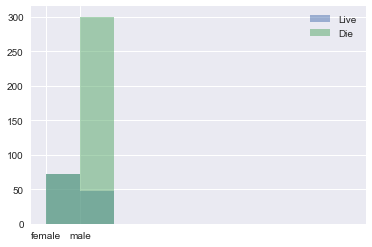

In [1042]:
#print(Train.columns, test.columns)
#print (Test[['Pclass', 'Sex']].groupby(['Pclass'], as_index=False).count())
#print (Train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())
#print (Train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())
#print (Train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean())
#print (Train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean())
#print (Train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean())
#print (Train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean())
#print (Train[["Cabin", "Survived"]].groupby(['Cabin'], as_index=False).mean())
plt.clf()
pltstr, pltrange = ("Sex", np.arange(0, 10, 1))
#Train['CabinNumber'] = Train['Cabin'].fillna("Z0").apply(lambda x: int(x.split(" ")[0][1:] + "0")/10)
#Train['CabinClass'] = Train['Cabin'].fillna("Z0").apply(lambda x: x.replace(" ", "")[0])
#Train['CabinClass'] = Train['CabinClass'].map( {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E':4, 'F':5, "G":6, "T":7, "Z":8}).astype(int)
Train.loc[(Train['Survived'] == 1) & (Train["Pclass"] == 3), pltstr].hist(bins=pltrange, alpha=0.5, label="Live")
Train.loc[(Train['Survived'] == 0) & (Train["Pclass"] == 3), pltstr].hist(bins=pltrange, alpha=0.5, label="Die")
#Train.loc[(Train['Survived'] == 1) & (Train["Pclass"] == 1)].plot.scatter(x = 'CabinNumber', y = 'CabinClass', alpha=0.5)
#Train.loc[(Train['Survived'] == 0) & (Train["Pclass"] == 1)].plot.scatter(x ='CabinNumber', y = 'CabinClass', alpha=0.5)
#Train.loc[Train['Survived'] == 1, pltstr].hist(bins=np.arange(0, 80, 2), alpha=0.5, label="Live")
#Train.loc[Train['Survived'] == 0, pltstr].hist(bins=np.arange(0, 80, 2), alpha=0.5, label="Die")
plt.legend()
plt.show()

In [1043]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return "Empty"

def get_number(name):
    if " " in name:
        s = name.split(" ")[1]
    else:
        s = name
    num_search = re.findall('\d+', s)
    # If the title exists, extract and return it.
    if num_search:
        return int(num_search[0])
    return 0

# Train['tickn'] = Train['Ticket'].apply(get_number)
# #print (Train[["tickn", "Survived"]].groupby(['tickn'], as_index=False).mean())
# Train.loc[Train['Survived'] == 1, 'tickn'].hist(bins=np.arange(0, 40000, 1000), alpha=0.5, label="live")
# Train.loc[Train['Survived'] == 0, 'tickn'].hist(bins=np.arange(0, 40000, 1000), alpha=0.5, label="die")
# plt.legend()
# plt.show()

In [1044]:
##full_data engineering

def class1(df):
    return copy.deepcopy(df.loc[(df["Pclass"] < 3) & (df["Sex"] == "female")])
def class2(df):
    return copy.deepcopy(df.loc[(df["Pclass"] == 3) & (df["Sex"] == "female")])
def class3(df):
    return copy.deepcopy(df.loc[(df["Pclass"] == 1) & (df["Sex"] == "male")])
def class4(df):
    return copy.deepcopy(df.loc[(df["Pclass"] > 1) & (df["Sex"] == "male")])

def split_class(df):
    return [class1(df), class2(df), class3(df), class4(df)]

#print(full_test[0]["PassengerId"].head(4), full_test_ID[0].head(4))

In [1142]:
def clean_feature(dataset):
    # Gives the length of the name
    dataset['Name_length'] = dataset['Name'].apply(len)
    ##dataset['Name_Space'] = dataset['Name'].apply(lambda x: len(x.split(" "))) ##highly correlated with lengt
    
    # Feature engineering steps taken from Sina
    # Create new feature FamilySize as a combination of SibSp and Parch
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['FamilySize'] = dataset['FamilySize'].apply(lambda x: 5 if (x >=5 and x < 8) else x) ##group family 5,6,7 to 5
    dataset['FamilySize'] = dataset['FamilySize'].apply(lambda x: 6 if x >= 8 else x) ##no family > 8 survived

    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    # Create a New feature of ticket number
    dataset['TickN'] = dataset['Ticket'].apply(get_number)
    dataset['TickN'] = dataset['TickN'] // 1000
    dataset['TickN'] = dataset['TickN'].astype(int)
    
    dataset['TickL'] = dataset['Ticket'].apply(lambda x: len(x))
    dataset['TickL'] = dataset['TickL'] // 2
    dataset['TickL'] = dataset['TickL'].astype(int)
        
    # Feature that tells whether a passenger had a cabin on the Titanic; not very useful
    dataset['CabinClass'] = dataset['Cabin'].fillna("Z0").apply(lambda x: x.replace(" ", "")[0])
    dataset['CabinClass'] = dataset['CabinClass'].map( 
        {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E':4, 'F':5, "G":6, "T":7, "Z":8}).astype(int)
    
    # Mapping CabinNumber
    #cabin_data       = dataset.groupby(['FamilySize'])['TickN']
    #dataset[CabinNumber]  = cabin_data.transform(lambda x: x.fillna(x.mean()))
    dataset['CabinNumber'] = dataset['Cabin'].fillna("Z0").apply(lambda x: int(x.split(" ")[0][1:] + "0")/10)
    dataset.loc[ dataset['CabinNumber'] <= 0, 'CabinNumber']                                    = 0
    dataset.loc[ (dataset['CabinNumber'] > 0) & (dataset['CabinNumber'] <= 10), 'CabinNumber']  = 1
    dataset.loc[ (dataset['CabinNumber'] > 10) & (dataset['CabinNumber'] <= 20), 'CabinNumber'] = 2
    dataset.loc[ (dataset['CabinNumber'] > 20) & (dataset['CabinNumber'] <= 30), 'CabinNumber'] = 3
    dataset.loc[ (dataset['CabinNumber'] > 30) & (dataset['CabinNumber'] <= 40), 'CabinNumber'] = 4
    dataset.loc[ (dataset['CabinNumber'] > 40), 'CabinNumber']  = 5
    dataset['CabinNumber'] = dataset['CabinNumber'].astype(int)
    
#     # Create a new feature Title, containing the titles of passenger names
#     dataset['Title'] = dataset['Name'].apply(get_title)
#     # Group all non-common titles into one single grouping "Rare"
#     dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
#     dataset['Title'] = dataset['Title'].replace('Mlle', 'Mrs')
#     dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
#     dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
#     # Mapping titles
#     title_mapping = {"Mr": 1, "Miss": 1, "Mrs": 1, "Rare": 2}
#     dataset['Title'] = dataset['Title'].map(title_mapping)
#     dataset['Title'] = dataset['Title'].fillna(5) ##This needs investigation
    
    # Mapping Sex
    ##dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping Embarked
    ###only 2 in the training are missing; all survived
    dataset['Embarked'] = dataset['Embarked'].fillna("C") 
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    # Create a new feature CategoricalFare
    ##fare_missing only in one test case; so doesn't matter;  some Fare have very low values in test
    dataset['Fare'] = dataset['Fare'].fillna(1)
    dataset.loc[(dataset['Fare'] >= 0) & (dataset['Fare'] <= 7.91), 'Fare']     = 1
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 100), 'Fare']      = 4
    dataset.loc[(dataset['Fare'] > 100), 'Fare']                                = 5
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Create a New feature CategoricalAge
    # This could be engineered by group!
    age_data       = dataset.groupby(['Sex', 'Pclass'])['Age']
    dataset['Age'] = age_data.transform(lambda x: x.fillna(x.mean()))
    dataset['Age'] = dataset['Age'].astype(int)
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 4, 'Age']                           = 0
    dataset.loc[(dataset['Age'] > 4) & (dataset['Age'] <= 16), 'Age']  = 1
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 24), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 24) & (dataset['Age'] <= 30), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 36), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 48), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 7
    
    ##drop the useless columns
    drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Sex', 'Pclass']
    #drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Sex', 'Pclass']
    dataset.drop(drop_elements, axis = 1, inplace=True)
    ##clean the ones with no Fare; safe to do
    dataset = dataset.loc[dataset["Fare"] > 0]
    return dataset

In [1143]:
## Data cleaining; only for training!
full_train = []
full_test  = []
full_train = split_class(Train)
full_test  = split_class(Test)
full_test_ID = [copy.deepcopy(df["PassengerId"]) for df in full_test]
post_full_train = [clean_feature(df) for df in full_train] 
post_full_test = [clean_feature(df) for df in full_test]
for i, df in enumerate(post_full_test):
    print(post_full_test[i].shape, full_test_ID[i].shape)

(80, 10) (80,)
(72, 10) (72,)
(57, 10) (57,)
(209, 10) (209,)


In [1144]:
##check if there is nan
def check_null(list_df):
    '''takes a list of dataframes'''
    for dataset in list_df:
        null_columns=dataset.columns[dataset.isnull().any()]
        if dataset.isnull().values.any():
            print(dataset[dataset.isnull().any(axis=1)][null_columns].head())
            
check_null(post_full_train)
check_null(post_full_test)

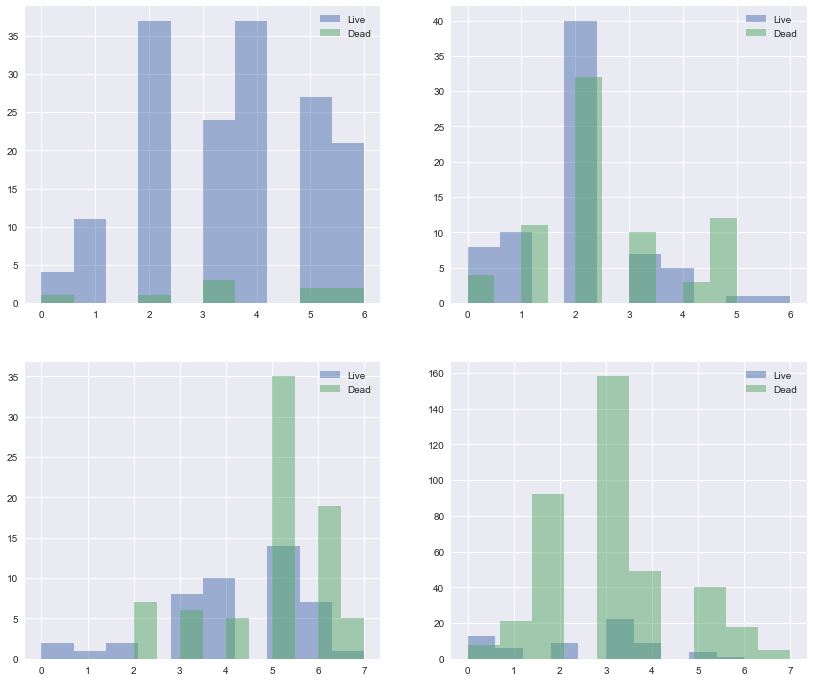

In [1145]:
pltstr = "Age"
plt.clf()
plt.figure(figsize=(14,12))
for i in range(len(post_full_train)):
    plt.subplot(221 + i)
    post_full_train[i].loc[(post_full_train[i]['Survived'] == 1), pltstr].hist(alpha=0.5, label="Live")
    post_full_train[i].loc[(post_full_train[i]['Survived'] == 0), pltstr].hist(alpha=0.5, label="Dead")
    plt.legend()
plt.show()

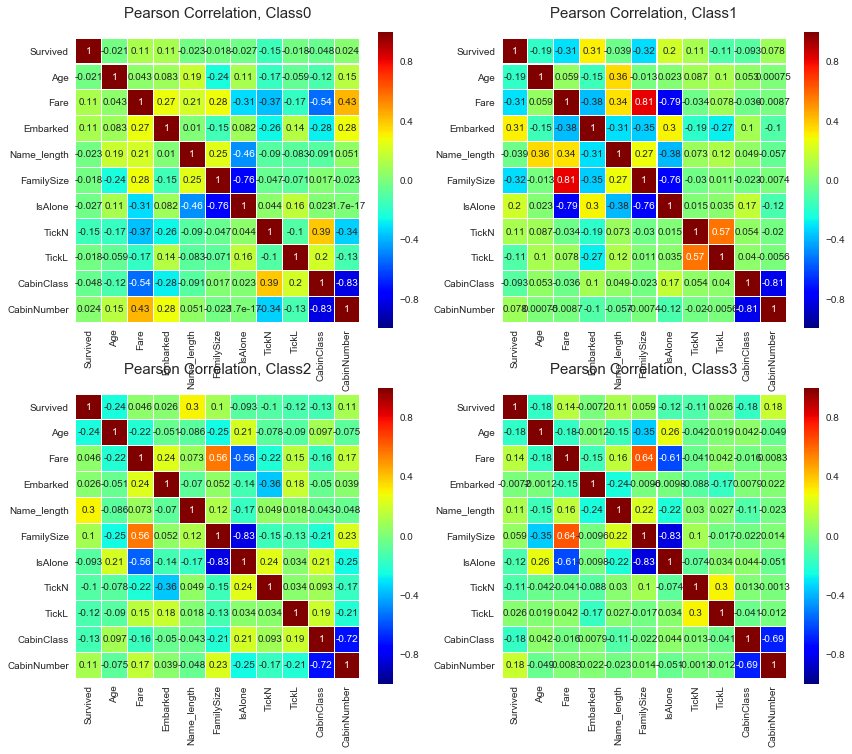

In [1146]:
colormap = plt.cm.jet
plt.clf()
plt.figure(figsize=(14,12))
for i in range(len(post_full_train)):
    plt.subplot(221 + i )
    plt.title('Pearson Correlation, Class' + str(i), y=1.05, size=15)
    sns.heatmap(post_full_train[i].astype(float).corr(),linewidths=0.1,vmax=1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

## Let's XGboost and CV this

In [1147]:
## A new more systematic approach
def modelfit(alg, data, useTrainCV=True, param_grid={}, cv_folds=5, early_stopping_rounds=50):
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
#https://www.dataiku.com/learn/guide/code/python/advanced-xgboost-tuning.html
    
    X_tr_temp = data["X_train"]
    y_tr_temp = data["y_train"]
    X_vr_temp = data["X_val"]
    y_vr_temp = data["y_val"]
    
    if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain["is_sig"].values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
        
        scoring = {'AUC': 'roc_auc', 'Accuracy': metrics.make_scorer(metrics.accuracy_score)}
        
        ##Randomized Search CV
        gsearch = RandomizedSearchCV(estimator = alg, param_distributions = param_grid, n_iter=80, cv=5, n_jobs=2)
        
        #Grid search CV
        #gsearch = GridSearchCV(estimator = alg, param_grid = param_grid, n_jobs=3, iid=False, cv=5, scoring=scoring, return_train_score=True, refit="AUC")
        
        ##Search
        gsearch.fit(X_tr_temp, y_tr_temp)
        
#         ##check trend
#         results = gsearch.cv_results_
#         plt.clf()
#         plt.figure(figsize=(13, 13))
#         plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)
#         plt.xlabel("Parameter")
#         plt.ylabel("Score")
#         plt.grid()

#         ax = plt.axes()
#         ax.set_xlim(0, 1)
#         ax.set_ylim(0.75, 1)

#         # Get the regular numpy array from the MaskedArray
#         X_axis = np.array(results['param_' + "min_child_weight"].data, dtype=float)

#         for scorer, color in zip(sorted(scoring), ['g', 'k']):
#             for sample, style in (('train', '--'), ('test', '-')):
#                 sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
#                 sample_score_std = results['std_%s_%s' % (sample, scorer)]
#                 ax.fill_between(X_axis, sample_score_mean - sample_score_std,
#                                 sample_score_mean + sample_score_std,
#                                 alpha=0.1 if sample == 'test' else 0, color=color)
#                 ax.plot(X_axis, sample_score_mean, style, color=color,
#                         alpha=1 if sample == 'test' else 0.7,
#                         label="%s (%s)" % (scorer, sample))

#             best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
#             best_score = results['mean_test_%s' % scorer][best_index]

#             # Plot a dotted vertical line at the best score for that scorer marked by x
#             ax.plot([X_axis[best_index], ] * 2, [0, best_score],
#                     linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

#             # Annotate the best score for that scorer
#             ax.annotate("%0.2f" % best_score,
#                         (X_axis[best_index], best_score + 0.005))

#         plt.legend(loc="best")
#         plt.grid('off')
#         plt.show()

        ## from the documentation
        best_parameters = gsearch.best_params_
        score = gsearch.best_score_
        print(best_parameters, score)
        alg = gsearch.best_estimator_
    
    ## fit alg
    #alg.fit(X_tr_temp, y_tr_temp)
    #XGboost specific
    alg.fit(X_tr_temp, y_tr_temp, eval_set=[(X_tr_temp, y_tr_temp), (X_vr_temp, y_vr_temp)], eval_metric="error", verbose=False)
    
    #Predict training set:
    tr_predictions = alg.predict(X_tr_temp)
    tr_predprob    = alg.predict_proba(X_tr_temp)[:,1]
    vr_predictions = alg.predict(X_vr_temp)
    vr_predprob    = alg.predict_proba(X_vr_temp)[:,1]
        
#     #Print model report:
#     print("Train Accuracy : %.3g" % metrics.accuracy_score(y_tr_temp.values, tr_predictions))
#     print("Train AUC Score (Train): %.3f" % metrics.roc_auc_score(y_tr_temp, tr_predprob))
#     #Validation report
#     print("Val Accuracy : %.3g" % metrics.accuracy_score(y_vr_temp.values, vr_predictions))
#     try:
#         print("Val AUC Score (Val): %.3f" % metrics.roc_auc_score(y_vr_temp, vr_predprob))
#     except ValueError:
#         print("Opps, 1")
    
    return alg

In [1152]:
# Test performance on test set
def evaluate(alg, data, dumb=None):
    '''data is a dictionary.'''
    X_te_temp = data["X_test"]
    y_te_temp = data["y_test"]
     
    if dumb == None: 
        te_predictions = alg.predict(X_te_temp)
        te_predprob    = alg.predict_proba(X_te_temp)[:,1]
    else: ## this is just using all 0 or 1s
        X_te_temp["pred"] = dumb
        X_dumb = X_te_temp["pred"] 
        te_predictions = X_dumb
        te_predprob = X_dumb
    #print(y_te_temp.values, te_predictions)
    test_acc = metrics.accuracy_score(y_te_temp.values, te_predictions)
#     #Print model report:
#     #print(CSI + "32;40m" + str(metrics.accuracy_score(y_vr_temp.values, vr_predictions)) + CSI + "0m")
#     print("Test Accuracy :  %.3g" % test_acc)
#     try:
#         print("Test AUC Score (Test): %.3f" % metrics.roc_auc_score(y_te_temp, te_predprob))
#     except ValueError:
#         print("Opps, 1")
    #Validation report
    return test_acc

def training(data, name="xgb_temp", optimize=False):
    '''data is a dictionary.'''
    param_grid = {
            'learning_rate': np.arange(1e-2, 1e-1, 5e-3), #np.arange(0.001, 0.3, 0.005), ##0.07
            'max_depth': [5], #np.arange(3, 6, 1), ##prefer smaller values, 4
            #'gamma' : np.arange(0.001, 0.01, 0.001), ##insensitive
            'n_estimators' : np.arange(25, 50, 5), ##best around 75
            #'colsample_bytree': [.6, .7, .8, .9, 1], ##best 1
            'reg_alpha' : np.arange(0.1, 1.0, 0.1), ##insensitive
            #'reg_lambda' : np.arange(0.1, 10.0, 0.1), ##insensitive
            #'subsample' : [.4, .5, .6, .7, ], ##best 1
            #'min_child_weight' : [.4, .5, .6, .7, .8],
            #'base_score' : [0.8], ##initial score
    }
    
    if optimize:
        xgb_temp = XGBClassifier(objective= 'binary:logistic', eval_metric='auc')
        xgb_temp = modelfit(xgb_temp, data, param_grid=param_grid)
        #joblib.dump(param_grid.best_estimator_, name + ".parlib.dat")
    else:
        xgb_temp = XGBClassifier(
            #max_depth = 4, #Maximum tree depth for base learners.
            #learning_rate = 1e-2, #Boosting learning rate (XGBoost's "eta")
            n_estimators= 25, ## Number of boosted trees, CV doesn't change after ~ 90
            ##silent = False, ##print messages or not
            objective= 'binary:logistic',
            eval_metric='auc',
            #nthread=-1,
            #gamma=0.01, #Minimum loss reduction required to make a further partition on a leaf node of the tree.
            #min_child_weight=1, # Minimum sum of instance weight(hessian) needed in a child.
            #scale_pos_weight=1,
            #reg_alpha=0.6,
            #reg_lambda=0.6,
            #subsample=0.7, #Subsample ratio of the training instance.
            #colsample_bytree = 0.7, #Subsample ratio of columns when constructing each tree.
            seed=24)
        xgb_temp = modelfit(xgb_temp, data, useTrainCV=False)
        #neigh = KNeighborsClassifier(n_neighbors=3)
        #neigh = RandomForestClassifier(n_estimators=200)
        #neigh = SVC(probability=True)
        #xgb_temp = modelfit(neigh, data, useTrainCV=False)
    
    ##save model
    joblib.dump(xgb_temp, name + ".joblib.dat")
    ##load model
    #loaded_model = joblib.load("pima.joblib.dat")
    
#     ##finish and plot
#     plt.clf()
#     fig = plt.figure(figsize=(10,6))
#     feat_imp = pd.Series(xgb_temp._Booster.get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
#     plt.show()
#     plt.savefig('Plot/feature_ranking_' + name + '.pdf')
    
    return xgb_temp


In [1153]:
## Try to add up sampling
def upsample(df):
    # Separate majority and minority classes
    df_dead = df[df.Survived==0]
    df_live = df[df.Survived==1] 
    
    n_dead = df_dead.shape[0]
    n_live = df_live.shape[0] 
    if n_dead > n_live * 3:
        # Upsample minority class
        df_temp = resample(df_live, replace=True, n_samples=n_dead//3, random_state=123) # reproducible results
        return pd.concat([df_dead, df_temp])
    elif n_live > n_dead * 3:
        # Upsample minority class
        df_temp = resample(df_dead, replace=True, n_samples=n_live//3, random_state=123) # reproducible results
        return pd.concat([df_live, df_temp])
    else:
        return pd.concat([df_live, df_dead])

# post_upsample_train = []
# for i, df in enumerate(post_full_train):
#     post_upsample_train.append(upsample(df))
#     print(post_upsample_train[i].shape, post_full_train[i].shape)

In [1154]:
def pack_data(df, split=0.05, shuffle=True):
    '''split data, and return a dictionary, containing training, testing and validation'''
    data = {}
    train_t, test_t = train_test_split(df, train_size=1 - split, test_size=split)
    train_t, val_t  = train_test_split(train_t, train_size=1 - split, test_size=split, shuffle=False)
    data["X_train"] = train_t.drop("Survived", axis=1)
    data["y_train"] = train_t["Survived"]
    data["X_val"]   = val_t.drop("Survived", axis=1)
    data["y_val"]   = val_t["Survived"]
    data["X_test"]  = test_t.drop("Survived", axis=1)
    data["y_test"]  = test_t["Survived"]
    return data

In [1155]:
xgb_models = {}
pred_results = {}
for i, df in enumerate(post_full_train):
    print("CLASS" + str(i) + "!!!")
    n_tests = 5
    test_results = np.zeros(n_tests)
    pred_results[i] = np.zeros(post_full_test[i].shape[0])
    for j in range(n_tests):
        data = pack_data(df)
        xgb_models[i] = training(data, name="xgb_" + str(i), optimize=True)
        test_results[j] = evaluate(xgb_models[i], data)
        pred_results[i] += xgb_models[i].predict(post_full_test[i])
    #print(test_results)
    pred_results[i] /= n_tests
    print(np.mean(test_results), np.std(test_results))

CLASS0!!!
{'reg_alpha': 0.90000000000000002, 'n_estimators': 35, 'max_depth': 5, 'learning_rate': 0.089999999999999983} 0.953947368421
{'reg_alpha': 0.70000000000000007, 'n_estimators': 35, 'max_depth': 5, 'learning_rate': 0.01} 0.947368421053
{'reg_alpha': 0.59999999999999998, 'n_estimators': 40, 'max_depth': 5, 'learning_rate': 0.074999999999999983} 0.940789473684
{'reg_alpha': 0.70000000000000007, 'n_estimators': 40, 'max_depth': 5, 'learning_rate': 0.069999999999999993} 0.940789473684
{'reg_alpha': 0.70000000000000007, 'n_estimators': 45, 'max_depth': 5, 'learning_rate': 0.049999999999999996} 0.947368421053
0.955555555556 0.0544331053952
CLASS1!!!
{'reg_alpha': 0.10000000000000001, 'n_estimators': 25, 'max_depth': 5, 'learning_rate': 0.054999999999999993} 0.728682170543
{'reg_alpha': 0.10000000000000001, 'n_estimators': 25, 'max_depth': 5, 'learning_rate': 0.049999999999999996} 0.68992248062
{'reg_alpha': 0.5, 'n_estimators': 45, 'max_depth': 5, 'learning_rate': 0.08999999999999998

In [1141]:
# Generate Submission File 
predictions = []
for i, model in xgb_models.items():
    predictions.append(np.round(pred_results[i]).astype(int))
    #print(predictions[i].shape, full_test_ID[i].shape)
IDs = [item for sublist in full_test_ID for item in sublist]
preds = [item for sublist in predictions for item in sublist]
submit = pd.DataFrame({ 'PassengerId': IDs, 'Survived': preds }).sort_values("PassengerId")
print(submit.head())
submit.to_csv("Data/Submission.csv", index=False)

     PassengerId  Survived
209          892         0
80           893         0
210          894         0
211          895         0
81           896         1
